**<div style="text-align: right;">The University of Chicago</div>**
<div style="text-align: right;">MS Financial Mathematics</div>

**<div style="text-align: left;">FINM 35000 - Topics in Economics</div>**
<div style="text-align: left;">Autumn 2024</div>

<h2><center> Data Project 2: Stress Testing an Equity Portfolio </center></h2>

### Team Members

- Antonio Pineda
- Kaleem Bukhari
- Raafay Uqaily
- Yasmine Outtara

### Import Statements

In [115]:
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.cm as cm
import statsmodels.api as sm
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from statsmodels.tsa.stattools import adfuller, kpss

import warnings
warnings.filterwarnings("ignore")

### Section 3.1 Portfolio Composition

Our first portfolio (EW PORTFOLIO WEIGHTS) is designed to balance sector diversification by equally allocating weights to three primary sectors—Financials, Healthcare, and Consumer Staples. Within each sector, stocks are equally weighted to maintain neutrality and ensure that the portfolio reflects sector-specific dynamics and their overall economic contributions.

Our second portfolio (EF PORTFOLIO WEIGHTS) employs mean-variance optimization to construct an efficient frontier allocation. By leveraging historical return data and the covariance structure of stocks, this portfolio seeks to maximize returns for a given level of risk. This approach prioritizes an optimized balance between risk and reward, favoring stocks with favorable return-risk tradeoffs. Together, these two portfolios provide complementary perspectives—one emphasizing diversification and simplicity, and the other focusing on optimal performance under historical and stress-testing conditions.

In [105]:
stock_data = {
    "STOCK": [
        "ARCHER-DANIELS-MIDLAND CO", "BANK OF AMERICA CORP", "BIOGEN INC", 
        "CITIGROUP INC", "CONAGRA BRANDS INC", "COLGATE-PALMOLIVE CO", 
        "CAMPBELL SOUP CO", "JOHNSON & JOHNSON", "JPMORGAN CHASE & CO", 
        "KELLANOVA", "COCA-COLA CO", "LILLY (ELI) & CO", "MERCK & CO", 
        "MORGAN STANLEY", "PFIZER INC", "PROCTER & GAMBLE CO", 
        "TYSON FOODS INC", "WALMART INC"
    ],
    "SECTOR": [
        "CONSUMER STAPLES", "FINANCIALS", "HEALTHCARE",
        "FINANCIALS", "CONSUMER STAPLES", "CONSUMER STAPLES",
        "CONSUMER STAPLES", "HEALTHCARE", "FINANCIALS",
        "CONSUMER STAPLES", "CONSUMER STAPLES", "HEALTHCARE",
        "HEALTHCARE", "FINANCIALS", "HEALTHCARE",
        "CONSUMER STAPLES", "CONSUMER STAPLES", "CONSUMER STAPLES"
    ]
}

portfolio = pd.DataFrame(stock_data)

sector_counts = portfolio['SECTOR'].value_counts()
sector_weights = {sector: 0.33 / count for sector, count in sector_counts.items()}
portfolio['EW PORTFOLIO WEIGHT'] = portfolio['SECTOR'].map(sector_weights)

portfolio = portfolio[["SECTOR", "STOCK", "EW PORTFOLIO WEIGHT"]]
portfolio = portfolio.sort_values(by="SECTOR")
portfolio = portfolio.reset_index(drop=True)

ef_weights_dict = {
    "ARCHER-DANIELS-MIDLAND CO": 0.0681024,
    "BANK OF AMERICA CORP": 0,
    "BIOGEN INC": 0.0835473,
    "CITIGROUP INC": 0,
    "CONAGRA BRANDS INC": 0,
    "COLGATE-PALMOLIVE CO": 0.0405726,
    "CAMPBELL SOUP CO": 0,
    "JOHNSON & JOHNSON": 0.0299107,
    "JPMORGAN CHASE & CO": 0.1521091,
    "KELLANOVA": 0.0084220,
    "COCA-COLA CO": 0,
    "LILLY (ELI) & CO": 0.2352803,
    "MERCK & CO": 0,
    "MORGAN STANLEY": 0,
    "PFIZER INC": 0,
    "PROCTER & GAMBLE CO": 0.2342193,
    "TYSON FOODS INC": 0.0060473,
    "WALMART INC": 0.1417890
}

portfolio["EF PORTFOLIO WEIGHTS"] = portfolio["STOCK"].map(ef_weights_dict)

portfolio

,SECTOR,STOCK,EW PORTFOLIO WEIGHT,EF PORTFOLIO WEIGHTS
0,CONSUMER STAPLES,ARCHER-DANIELS-MIDLAND CO,0.036667,0.068102
1,CONSUMER STAPLES,PROCTER & GAMBLE CO,0.036667,0.234219
2,CONSUMER STAPLES,COCA-COLA CO,0.036667,0.000000
3,CONSUMER STAPLES,KELLANOVA,0.036667,0.008422
4,CONSUMER STAPLES,TYSON FOODS INC,0.036667,0.006047
5,CONSUMER STAPLES,CAMPBELL SOUP CO,0.036667,0.000000
6,CONSUMER STAPLES,WALMART INC,0.036667,0.141789
7,CONSUMER STAPLES,CONAGRA BRANDS INC,0.036667,0.000000
8,CONSUMER STAPLES,COLGATE-PALMOLIVE CO,0.036667,0.040573
9,FINANCIALS,CITIGROUP INC,0.082500,0.000000


In [120]:
wrds_data = pd.read_excel("wrds_data.xlsx", sheet_name="returns", usecols="A:AB")
historic_mev_data = pd.read_csv("2024-Table_2A_Historic_Domestic.csv")
baseline_mev_data = pd.read_csv("2024-Table_3A_Supervisory_Baseline_Domestic.csv")
severe_mev_data = pd.read_csv("2024-Table_4A_Supervisory_Severely_Adverse_Domestic.csv")

In [107]:
portfolio_returns = wrds_data.iloc[:, :-3]

columns_to_drop = [portfolio_returns.columns[-2], portfolio_returns.columns[-4]]
portfolio_returns = portfolio_returns.drop(columns=columns_to_drop)

portfolio_returns['Date'] = pd.to_datetime(portfolio_returns['Date'])
portfolio_returns.set_index('Date', inplace=True)

portfolio_returns = portfolio_returns.drop(columns=['KRAFT HEINZ CO', 'GOLDMAN SACHS GROUP INC'])
portfolio_returns.columns.values[-4] = "TYSON FOODS INC"
portfolio_returns = portfolio_returns.dropna()

weights = dict(zip(portfolio["STOCK"], portfolio["EW PORTFOLIO WEIGHT"]))

portfolio_returns["EW Portfolio Returns"] = portfolio_returns[list(weights.keys())].mul(list(weights.values()), axis=1).sum(axis=1)

In [111]:
# Define the mean-variance optimization function
def mean_variance_optimization(returns, risk_free_rate):
    n = returns.shape[1]
    mean_returns = returns.mean()
    cov_matrix = returns.cov()
    
    # Objective function: Maximize Sharpe ratio (equivalent to minimizing negative Sharpe ratio)
    def negative_sharpe_ratio(weights):
        portfolio_return = weights @ mean_returns
        portfolio_volatility = np.sqrt(weights.T @ cov_matrix @ weights)
        return -(portfolio_return - risk_free_rate.mean()) / portfolio_volatility

    # Constraint: Weights sum to 1
    constraints = [{"type": "eq", "fun": lambda weights: np.sum(weights) - 1}]
    
    # Bounds for weights: No short-selling
    bounds = [(0, 1) for _ in range(n)]
    
    # Initial guess (equal weights)
    initial_weights = np.ones(n) / n
    
    # Optimization
    result = minimize(negative_sharpe_ratio, initial_weights, bounds=bounds, constraints=constraints)
    return result.x

stock_returns = portfolio_returns.iloc[:, 0:18]
risk_free_rate = portfolio_returns.iloc[:, 19]

ef_weights = mean_variance_optimization(stock_returns, risk_free_rate)

portfolio_returns["EF Portfolio Returns"] = stock_returns.mul(ef_weights, axis=1).sum(axis=1)
portfolio_returns.head()

,ARCHER-DANIELS-MIDLAND CO,BANK OF AMERICA CORP,BIOGEN INC,CITIGROUP INC,CONAGRA BRANDS INC,COLGATE-PALMOLIVE CO,CAMPBELL SOUP CO,JOHNSON & JOHNSON,JPMORGAN CHASE & CO,KELLANOVA,...,MERCK & CO,MORGAN STANLEY,PFIZER INC,PROCTER & GAMBLE CO,TYSON FOODS INC,WALMART INC,S&P RETURN,RISK-FREE RATE,EW Portfolio Returns,EF Portfolio Returns
Date,,,,,,,,,,,,,,,,,,,,,
1991-10-01,0.0683,0.0491,-0.0133,0.0282,-0.0811,-0.0257,0.0338,0.0764,-0.0246,-0.0634,...,0.0548,0.0813,0.0998,-0.0088,0.0385,-0.0314,0.0119,0.0042,0.021688,-0.014267
1991-11-01,0.0009,-0.0803,-0.3514,-0.1031,0.0695,0.0120,0.0032,0.0173,-0.1465,0.0597,...,0.0665,-0.0162,-0.0687,-0.0314,-0.0736,0.0568,-0.0439,0.0039,-0.048011,-0.058620
1991-12-01,0.2100,0.1926,0.0833,0.2069,0.1768,0.1568,0.0950,0.1881,0.0201,0.2220,...,0.1418,0.1972,0.2655,0.1590,0.0733,0.2055,0.1116,0.0038,0.158020,0.137019
1992-01-01,-0.1019,0.0800,0.1923,0.0571,-0.0596,-0.0304,-0.1076,-0.0611,0.3176,-0.1319,...,-0.0563,-0.1100,-0.1310,0.1105,-0.0994,-0.0849,-0.0199,0.0034,0.001297,0.053472
1992-02-01,-0.0118,0.0826,-0.0968,0.0000,-0.1617,0.0000,-0.0066,-0.0544,0.2009,0.0093,...,0.0032,-0.0089,0.0256,-0.0205,0.0143,0.0023,0.0096,0.0028,0.007296,0.005448


In [109]:
weights_df = pd.DataFrame({
    "Stock Name": stock_returns.columns,
    "EF Weights": ef_weights
})

In [138]:
final_portfolio_returns = portfolio_returns[["EW Portfolio Returns", "EF Portfolio Returns"]]
final_portfolio_returns.to_csv("final_portfolio_returns.csv", index=True)

---

### Section 3.2 Portfolio Data Processing

We can start processing data by first looking at the number of missing data points for each of the 20 stock returns given in the wrds_data excel file. 

In [110]:
returns_data = wrds_data.iloc[:, 1:-7]

missing_returns_data_count = returns_data.isna().sum()
returns_data_start_date = returns_data.apply(lambda col: col.first_valid_index())

missing_data = pd.DataFrame({
    "Missing Returns Data Count": missing_returns_data_count,
    "Start Date": returns_data_start_date
})

missing_data

,Missing Returns Data Count,Start Date
ARCHER-DANIELS-MIDLAND CO,15,15
BANK OF AMERICA CORP,0,0
BIOGEN INC,345,345
CITIGROUP INC,286,286
CONAGRA BRANDS INC,61,61
COLGATE-PALMOLIVE CO,0,0
CAMPBELL SOUP CO,0,0
GOLDMAN SACHS GROUP INC,437,437
JOHNSON & JOHNSON,0,0
JPMORGAN CHASE & CO,0,0


As shown above, 9 out of the 20 stocks have at least some missing data. Since the project requires at least 15 stocks in the portfolio and we would ideally want to maximize our data points for developing a robust prediction model, we chose to eliminate 'KRAFT HEINZ CO' and 'GOLDMAN SACHS GROUP INC' from consideration. This will enable us to use complete returns data from October 1991 to December 2023 without having to use forward filling, back filling, or interpolation techniques to fill in missing values.

Although we have addressed missing data concerns for our specific dataset as described above, here are some generic methods we could apply in different scenarios:

1. Missing Data for Sub-Portfolios or Prediction Models - Sparse missing values in individual stock returns can be imputed to maintain consistency across observations using several approaches like:
- **Forward or Backward Filling**: Filling missing values with the most recent or subsequent available return for that stock.
- **Mean Imputation**: Replacing missing values with the average return of that stock across the dataset.
- **Industry or Sector-Based Imputation**: Replacing missing values with the average return of other stocks in the same industry or sector for that period.

2. Excessive Missing Data - Stocks with a high proportion of missing data may be entirely excluded to avoid introducing excessive noise or bias. Forwardfilling or backfilling may not be appropriate here, especially if companies are listed at different times, because doing so would introduce unrealistic data points. To address this concern, sub-portfolios can be constructed on the basis of listing date. 

Additionally, there are several strategies one can use to group stocks into sub-portfolios based on meaningful classifications to create more targeted predictive models.

Example groupings:
- **Industry-Based Clustering**: Group stocks by sectors like Consumer Staples, Financials, Healthcare, etc.
- **Market Cap-Based Clustering**: Divide stocks into large-cap, mid-cap, and small-cap categories.
- **Volatility-Based Clustering**: Group stocks with similar historical volatility or beta values.

Furthermore, below are some pros and cons for different types of portfolio models that can be used.

#### Sub-Portfolio Models:
**Pros**:
- Simplifies the problem by reducing the number of predictive models.
- Sub-portfolios can capture shared characteristics (e.g., sector trends or macroeconomic sensitivities).

**Cons**:
- Loss of granularity, as individual stock-specific patterns are averaged out.
- Requires careful selection of grouping criteria to avoid introducing bias.

#### Individual Stock Models:
**Pros**:
- Captures unique return dynamics of each stock.
- Allows for high precision in prediction if data is sufficient.

**Cons**:
- Computationally intensive for large portfolios.
- Performance may degrade if stocks have sparse or inconsistent data.

#### Single Portfolio-Wide Model:
**Pros**:
- Simplifies computation by treating the portfolio as a single entity.
- Reduces the need for imputation or clustering decisions.

**Cons**:
- Ignores individual stock or group-level differences.
- May perform poorly if the portfolio is highly heterogeneous.

---

### Section 3.3 Portfolio Data Sources

For the scope of this project, no external data sources beyond the files provided were used. 

1. **WRDS Data** (`wrds_data.xlsx`)
   - File contains monthly returns for 20 different listed stocks, S&P500, Fama-French factors, and risk-free rate starting from 1963.

2. **Historic Domestic MEVs** (`2024-Table_2A_Historic_Domestic.csv`)
   - File contains historical values of several macroeconomic variables ranging from 1976 to 2023.

3. **Supervisory Baseline Scenario** (`2024-Table_3A_Supervisory_Baseline_Domestic.csv`)
   - File contains projected values of several macroeconomic variables under baseline economic conditions from 2024 to 2027.

4. **Supervisory Severely Adverse Scenario** (`2024-Table_4A_Supervisory_Severely_Adverse_Domestic.csv`)
   - File contains projected values of several macroeconomic variables under a severely adverse economic conditions from 2024 to 2027.

---

### Section 3.4 MEV Stationarity Testing

Before running stationarity tests on the MEV's, we plotted the time series graphs for all variables to see if we could visually determine any variables with exponential growth or multiplicative trends for potential log transformations instead of simply taking the first difference. 

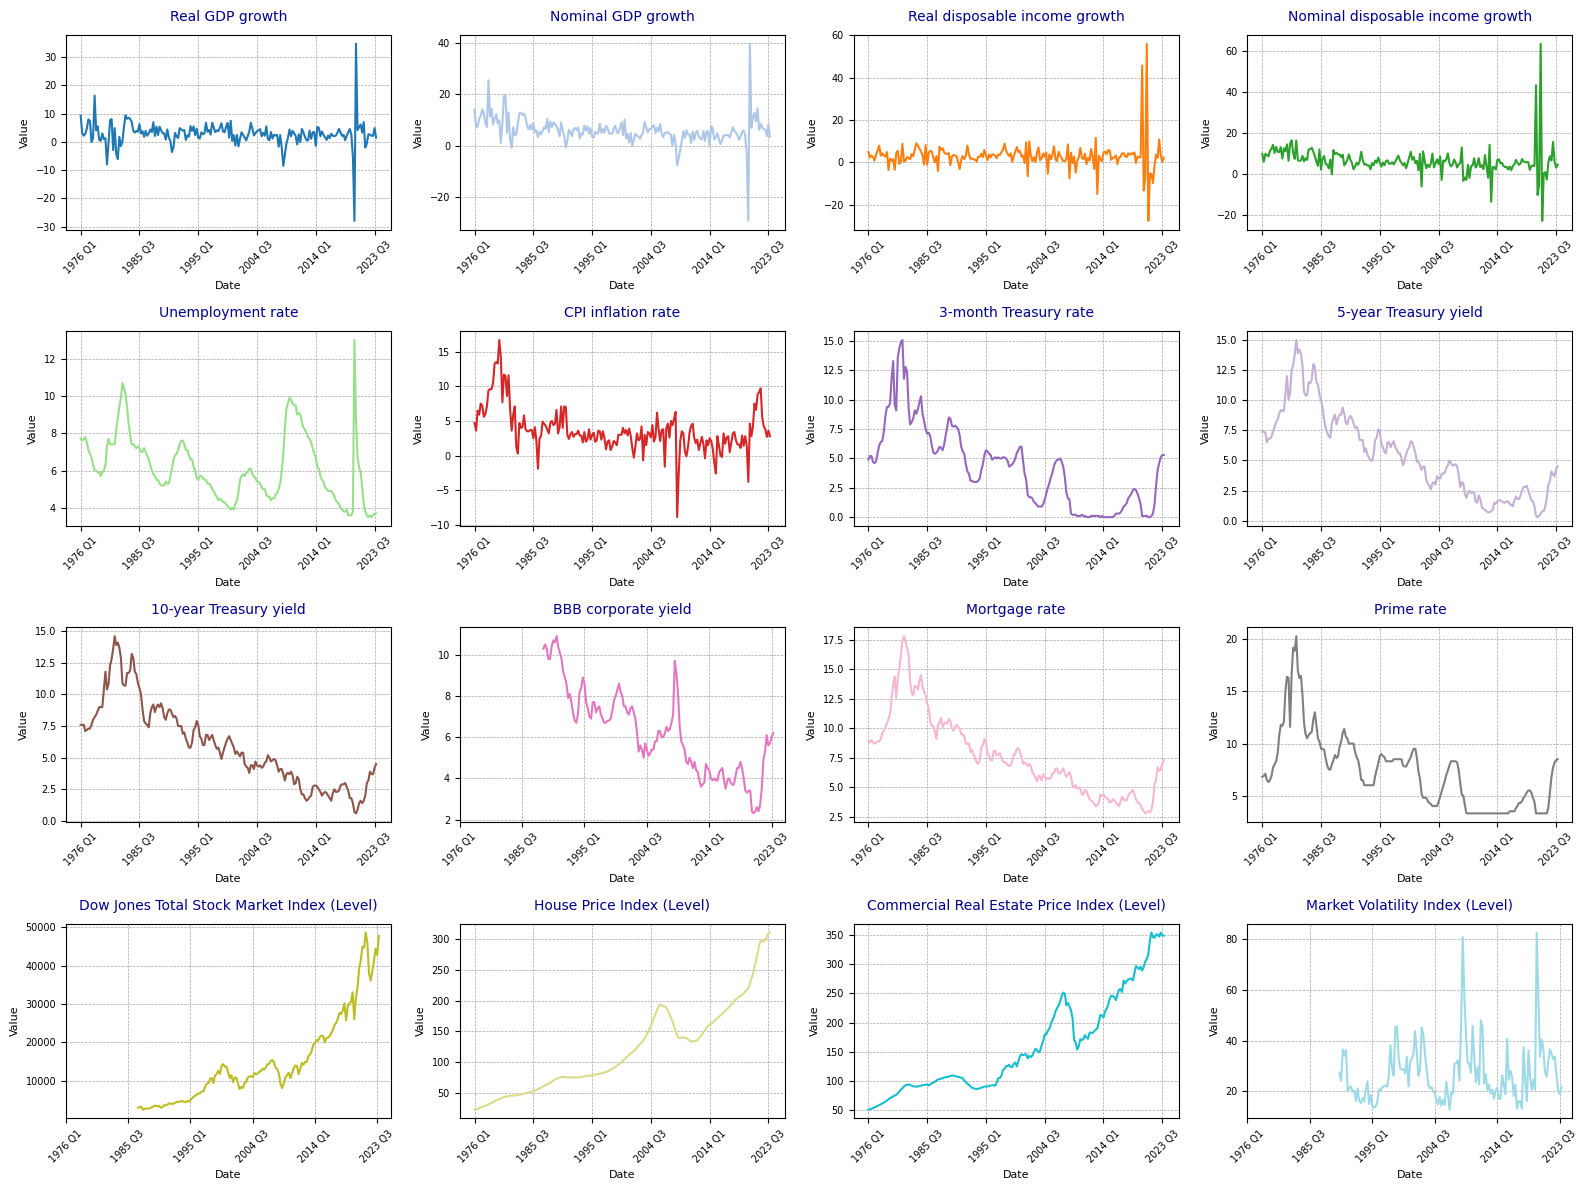

In [121]:
historic_mev_data = historic_mev_data.drop(columns=['Scenario Name'])
historic_mev_data.set_index('Date', inplace=True)

plt.figure(figsize=(16, 12))

columns_to_check = historic_mev_data.columns
colors = cm.tab20(np.linspace(0, 1, len(columns_to_check)))  

n_cols = 4  
n_rows = int(np.ceil(len(columns_to_check) / n_cols))  

for i, (column, color) in enumerate(zip(columns_to_check, colors)):
    plt.subplot(n_rows, n_cols, i + 1)

    plt.plot(historic_mev_data.index, historic_mev_data[column], color=color, linewidth=1.5)

    plt.title(column, fontsize=10, color="darkblue", pad=10)
    plt.xlabel('Date', fontsize=8)
    plt.ylabel('Value', fontsize=8)

    plt.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.7)
    plt.xticks(historic_mev_data.index[::len(historic_mev_data) // 5], rotation=45, fontsize=7)
    plt.yticks(fontsize=7)

plt.tight_layout()
plt.show()

Based on the graphs above, Dow Jones Total Stock Market Index (Level), House Price Index (Level) and Commercial Real Estate Price Index (Level) displace exponential growth and may need to undergo log transformation before differencing.

In [136]:
def adf_test(series):
    result = adfuller(series.dropna(), autolag='AIC')
    adf_stat = result[0]
    p_value = result[1]
    is_stationary = p_value < 0.05  # Stationary if p-value < 0.05
    return {"ADF Statistic": adf_stat, "p-value": p_value, "Stationary": is_stationary}

log_columns = [
    "Dow Jones Total Stock Market Index (Level)", 
    "House Price Index (Level)", 
    "Commercial Real Estate Price Index (Level)"
]

transformed_data = historic_mev_data.copy()

pre_transformation_results = {}

for col in log_columns:
    if col in transformed_data.columns:
        transformed_data[col] = np.log(transformed_data[col])
        print(f"Log transformation applied to {col}.")

for col in historic_mev_data.columns:
    pre_transformation_results[col] = adf_test(historic_mev_data[col])

for col in transformed_data.columns:
    adf_result = adf_test(transformed_data[col])
    if not adf_result["Stationary"]:
        transformed_data[col] = transformed_data[col].diff()
        transformed_data.rename(columns={col: f"{col}_diff"}, inplace=True)
        print(f"First differencing applied to {col} (non-stationary). Renamed to {col}_diff.")

post_transformation_results = {}
for col in transformed_data.columns:
    post_transformation_results[col] = adf_test(transformed_data[col])

pre_results_df = pd.DataFrame(pre_transformation_results).T
post_results_df = pd.DataFrame(post_transformation_results).T

pre_results_df.columns = ["ADF Statistic", "p-value", "Stationary"]
post_results_df.columns = ["ADF Statistic", "p-value", "Stationary"]

transformed_data.dropna(inplace=True)

print("\nPre-Transformation Stationarity Test Results:")
print(pre_results_df)

print("\nPost-Transformation Stationarity Test Results:")
print(post_results_df)

Log transformation applied to Dow Jones Total Stock Market Index (Level).
Log transformation applied to House Price Index (Level).
Log transformation applied to Commercial Real Estate Price Index (Level).
First differencing applied to Nominal disposable income growth (non-stationary). Renamed to Nominal disposable income growth_diff.
First differencing applied to CPI inflation rate (non-stationary). Renamed to CPI inflation rate_diff.
First differencing applied to 3-month Treasury rate (non-stationary). Renamed to 3-month Treasury rate_diff.
First differencing applied to 5-year Treasury yield (non-stationary). Renamed to 5-year Treasury yield_diff.
First differencing applied to 10-year Treasury yield (non-stationary). Renamed to 10-year Treasury yield_diff.
First differencing applied to BBB corporate yield (non-stationary). Renamed to BBB corporate yield_diff.
First differencing applied to Mortgage rate (non-stationary). Renamed to Mortgage rate_diff.
First differencing applied to Prim

The stationarity testing and transformations applied to the macroeconomic variables (MEVs) showed mixed results across growth rates, interest rates, and index levels. Key growth rates such as Real GDP growth, Nominal GDP growth, and Real disposable income growth were found to be stationary, requiring no transformation. However, most rates (e.g., CPI inflation rate, 3-month Treasury rate, and 10-year Treasury yield) were non-stationary and required first differencing to remove trends and achieve stationarity. These rates typically exhibit linear trends over time, which are effectively addressed by differencing.

Log transformations were applied to pre-specified variables exhibiting exponential growth, such as the Dow Jones Total Stock Market Index, House Price Index, and Commercial Real Estate Price Index. These transformations stabilized variance and linearized exponential trends. For these variables, first differencing was subsequently applied to ensure full stationarity. The Market Volatility Index, while a level variable, was found to be inherently stationary and did not require any transformation.

In summary, the analysis involved a methodical application of log transformations for variables with exponential growth and first differencing for variables with linear trends. Post-transformation stationarity testing confirmed that all variables are now stationary, meeting the prerequisites for additional modeling and predictive analysis. 

---

### Section 3.5 Summary Statistics

In [126]:
portfolio_returns_statistics = portfolio_returns.describe()
portfolio_returns_statistics = portfolio_returns_statistics.T
portfolio_returns_statistics

,count,mean,std,min,25%,50%,75%,max
ARCHER-DANIELS-MIDLAND CO,387.0,0.009435,0.077287,-0.268100,-0.035600,0.007600,0.055850,0.327100
BANK OF AMERICA CORP,387.0,0.011250,0.103860,-0.532700,-0.039900,0.010000,0.067450,0.729100
BIOGEN INC,387.0,0.022445,0.150643,-0.405000,-0.052550,0.010000,0.091350,0.838400
CITIGROUP INC,387.0,0.009937,0.113029,-0.577500,-0.050150,0.009900,0.068550,0.686700
CONAGRA BRANDS INC,387.0,0.007281,0.068620,-0.339500,-0.032650,0.010300,0.047100,0.221900
COLGATE-PALMOLIVE CO,387.0,0.010493,0.059448,-0.218200,-0.020050,0.011000,0.041200,0.325800
CAMPBELL SOUP CO,387.0,0.006352,0.060736,-0.181600,-0.028400,0.010600,0.045300,0.205100
JOHNSON & JOHNSON,387.0,0.010261,0.053249,-0.160100,-0.024600,0.010900,0.041650,0.188100
JPMORGAN CHASE & CO,387.0,0.014097,0.087634,-0.305800,-0.033200,0.014500,0.064550,0.325700
KELLANOVA,387.0,0.006054,0.056636,-0.213000,-0.025850,0.007800,0.038150,0.262700


In [132]:
pr_min_date = portfolio_returns.index.min()
pr_max_date = portfolio_returns.index.max()

print(f"Minimum date in portfolio_returns: {pr_min_date}")
print(f"Maximum date in portfolio_returns: {pr_max_date}")

Minimum date in portfolio_returns: 1991-10-01 00:00:00
Maximum date in portfolio_returns: 2023-12-01 00:00:00


In [137]:
mev_summary_statistics = transformed_data.describe()
mev_summary_statistics = mev_summary_statistics.T
mev_summary_statistics

,count,mean,std,min,25%,50%,75%,max
Real GDP growth,136.0,2.541912,4.532672,-28.000000,1.475000,2.550000,4.025000,34.800000
Nominal GDP growth,136.0,4.873529,5.098456,-29.200000,3.600000,5.000000,6.500000,39.700000
Real disposable income growth,136.0,2.811029,7.538795,-27.600000,1.200000,2.750000,4.225000,56.000000
Nominal disposable income growth_diff,136.0,-0.017647,12.432013,-86.600000,-1.925000,0.200000,2.000000,69.300000
Unemployment rate,136.0,5.758088,1.742946,3.500000,4.475000,5.400000,6.700000,13.000000
CPI inflation rate_diff,136.0,-0.009559,2.423462,-15.200000,-1.200000,0.000000,1.025000,8.400000
3-month Treasury rate_diff,136.0,-0.017647,0.426334,-1.300000,-0.100000,0.000000,0.200000,1.600000
5-year Treasury yield_diff,136.0,-0.025735,0.415977,-1.100000,-0.300000,0.000000,0.200000,1.200000
10-year Treasury yield_diff,136.0,-0.025735,0.368178,-0.900000,-0.300000,0.000000,0.200000,1.000000
BBB corporate yield_diff,136.0,-0.026471,0.484613,-1.600000,-0.300000,0.000000,0.225000,2.600000


In [134]:
mev_min_date = transformed_data.index.min()
mev_max_date = transformed_data.index.max()

print(f"Minimum date in portfolio_returns: {mev_min_date}")
print(f"Maximum date in portfolio_returns: {mev_max_date}")

Minimum date in portfolio_returns: 1990 Q1
Maximum date in portfolio_returns: 2023 Q4


The summary statistics reveal key insights into portfolio performance and macroeconomic variables (MEVs). The EF Portfolio Returns, with a mean of 1.26%, outperform the EW Portfolio Returns, which have a mean of 1.12%. The EF Portfolio also exhibits lower volatility, with a standard deviation of 4.22% compared to 4.77% for the EW Portfolio. This demonstrates the effectiveness of mean-variance optimization in achieving higher risk-adjusted returns. 

Most MEVs have reasonable ranges, reflecting both economic expansions and contractions over the covered time period. For instance, Real GDP growth and Nominal GDP growth show mean values of approximately 2.54% and 4.88%, respectively, which align with typical economic growth rates over long periods. However, these variables also show significant variability, with minimum values of -28% and -29.2%, reflecting severe economic downturns such as recessions or crises. The maximum growth rates, particularly for Nominal GDP at 39.7%, may reflect periods of rapid expansion or high inflation.

The Unemployment rate exhibits relatively stable variability, with a mean of 5.76% and a standard deviation of 1.75%. Its range (3.5% to 13%) captures historical lows during economic booms and peaks during periods of unemployment surges, such as recessions. In financial indicators, Treasury yields (3-month, 5-year, and 10-year) and corporate yields exhibit close-to-zero mean values, reflecting long periods of low interest rate changes. 

Overall, these statistics highlight the diversity and volatility inherent in macroeconomic and financial indicators. The wide variability in certain metrics underscores the importance of robust statistical modeling to capture the dynamics and mitigate the impact of outliers in stress-testing scenarios. 

In [139]:
def summary_statistics(returns, annual_factor=12):
    summary_statistics = pd.DataFrame(index=returns.columns)
    summary_statistics['Mean'] = returns.mean() * annual_factor
    summary_statistics['Vol'] = returns.std() * np.sqrt(annual_factor)
    summary_statistics['Sharpe'] = (returns.mean() / returns.std()) * np.sqrt(annual_factor)
    summary_statistics['Min'] = returns.min()
    summary_statistics['Max'] = returns.max()
    summary_statistics['Skewness'] = returns.skew()
    summary_statistics['Excess Kurtosis'] = returns.kurtosis()
    summary_statistics['VaR (0.05)'] = returns.quantile(.05, axis=0)
    summary_statistics['CVaR (0.05)'] = returns[returns <= returns.quantile(.05, axis=0)].mean()
    return summary_statistics

portfolio_summary_stats = summary_statistics(final_portfolio_returns)
portfolio_summary_stats

,Mean,Vol,Sharpe,Min,Max,Skewness,Excess Kurtosis,VaR (0.05),CVaR (0.05)
EW Portfolio Returns,0.134273,0.165445,0.811591,-0.178845,0.193205,-0.140060,1.773425,-0.065524,-0.096565
EF Portfolio Returns,0.150923,0.147609,1.022451,-0.125704,0.189101,0.033717,0.715608,-0.055699,-0.078318


The comparison between the Equally Weighted (EW) Portfolio Returns and Efficient Frontier (EF) Portfolio Returns reveals that the EF Portfolio outperforms the EW Portfolio on multiple dimensions. The EF Portfolio achieves a higher mean return of 0.1509 compared to 0.1343 for the EW Portfolio while exhibiting lower volatility (0.1476 vs. 0.1654). This results in a superior Sharpe ratio for the EF Portfolio (1.0225 vs. 0.8116), indicating better risk-adjusted performance. The EF Portfolio's improved performance stems from its optimized allocation, which balances returns and risk more effectively than an equally weighted approach.

From a risk perspective, the EF Portfolio demonstrates lower downside risk as measured by Value at Risk (VaR) at the 5% level (-0.0557 vs. -0.0655 for EW) and Conditional Value at Risk (CVaR) (-0.0783 vs. -0.0966 for EW). Additionally, the EF Portfolio exhibits near-zero skewness (0.0337) compared to the slight negative skewness of the EW Portfolio (-0.1401), suggesting a more symmetric return distribution. The lower excess kurtosis of the EF Portfolio (0.7156 vs. 1.7734) further indicates reduced likelihood of extreme return events. These metrics underscore the EF Portfolio's ability to deliver more consistent and stable returns while effectively mitigating extreme downside risks.

In [141]:
stock_to_sector = dict(zip(portfolio["STOCK"], portfolio["SECTOR"]))

sector_returns_data = {}

for sector in portfolio["SECTOR"].unique():
    stocks_in_sector = [stock for stock, sec in stock_to_sector.items() if sec == sector]
    sector_returns_data[sector] = portfolio_returns[stocks_in_sector].mean(axis=1)

sector_returns = pd.DataFrame(sector_returns_data)

sector_summary_stats = summary_statistics(sector_returns)
sector_summary_stats

,Mean,Vol,Sharpe,Min,Max,Skewness,Excess Kurtosis,VaR (0.05),CVaR (0.05)
CONSUMER STAPLES,0.102995,0.138015,0.746256,-0.130356,0.161689,-0.105897,1.613104,-0.056732,-0.083036
FINANCIALS,0.147525,0.303660,0.485823,-0.314500,0.436075,-0.076826,2.427108,-0.134728,-0.193088
HEALTHCARE,0.156370,0.198502,0.787749,-0.148240,0.278520,0.310017,0.981961,-0.077614,-0.102548


The sector-level returns analysis highlights notable differences in performance and risk across the three sectors. Healthcare exhibits the highest mean return (15.64%) with moderate volatility (19.85%) and the strongest Sharpe ratio (0.788), indicating superior risk-adjusted performance. Financials, while delivering a slightly lower mean return (14.75%), demonstrates significantly higher volatility (30.37%), resulting in the lowest Sharpe ratio (0.486). Consumer Staples, on the other hand, show the lowest mean return (10.30%) and volatility (13.80%), with a moderate Sharpe ratio (0.746), reflecting stability but limited growth potential. The skewness and kurtosis metrics suggest more symmetric return distributions for Financials and Consumer Staples, whereas Healthcare shows mild positive skewness. The Value at Risk (VaR) and Conditional Value at Risk (CVaR) measures reinforce that Healthcare has relatively moderate downside risk, while Financials are the most exposed to extreme negative outcomes. Overall, Healthcare emerges as the most resilient sector, combining strong returns with manageable risk.

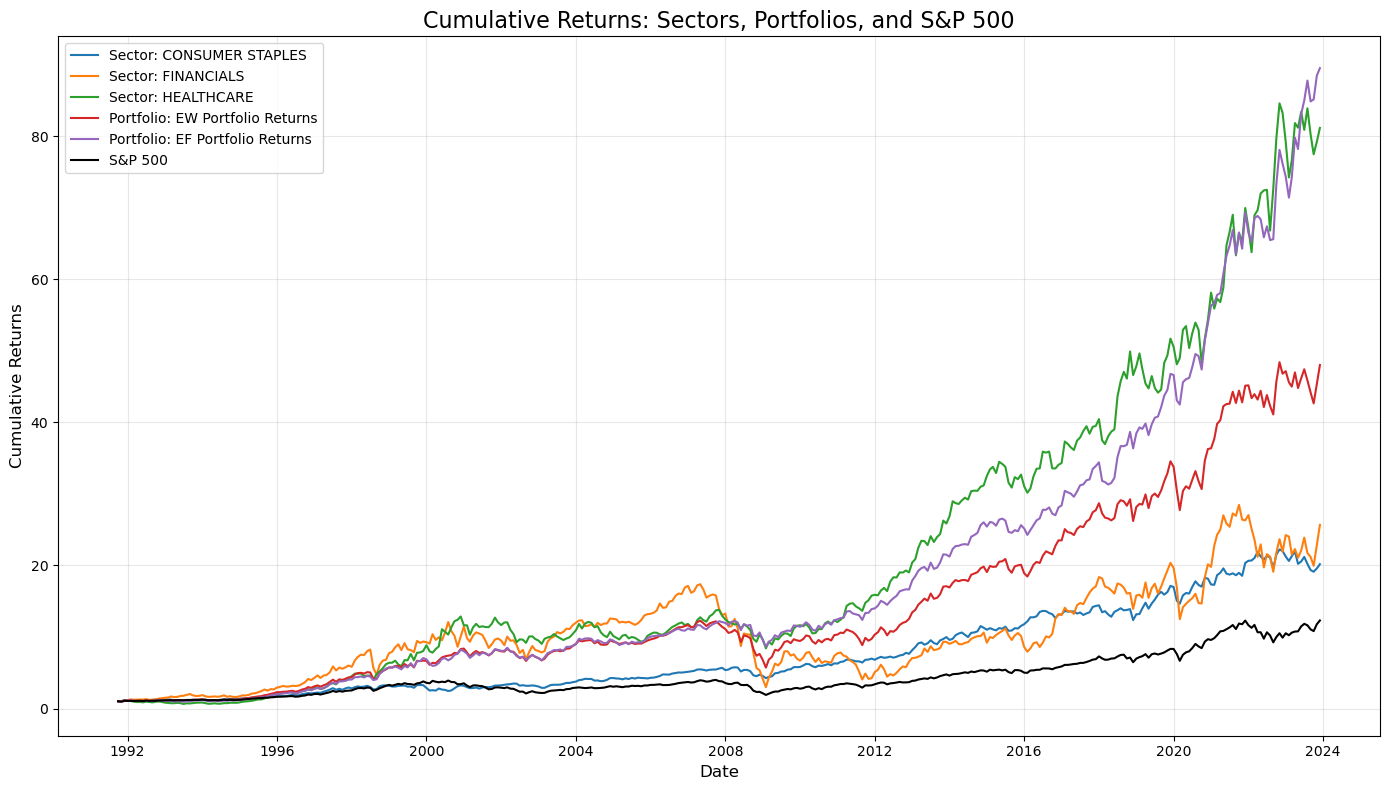

In [145]:
cumulative_sector_returns = (1 + sector_returns).cumprod()
cumulative_portfolio_returns = (1 + final_portfolio_returns).cumprod()
cumulative_sp500_returns = (1 + portfolio_returns["S&P RETURN"]).cumprod()

plt.figure(figsize=(14, 8))

for column in cumulative_sector_returns.columns:
    plt.plot(cumulative_sector_returns.index, cumulative_sector_returns[column], label=f"Sector: {column}")

for column in cumulative_portfolio_returns.columns:
    plt.plot(cumulative_portfolio_returns.index, cumulative_portfolio_returns[column], label=f"Portfolio: {column}")

plt.plot(cumulative_sp500_returns.index, cumulative_sp500_returns, label="S&P 500", color="black")

plt.title("Cumulative Returns: Sectors, Portfolios, and S&P 500", fontsize=16)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Cumulative Returns", fontsize=12)
plt.legend(fontsize=10, loc="upper left")
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

The cumulative returns plot shows that the Healthcare sector consistently outperforms other sectors and portfolios over time, reflecting its resilience and strong growth potential. The EF Portfolio Returns closely track the performance of the Healthcare sector, suggesting its optimized allocation leans toward higher-performing assets. In contrast, the EW Portfolio Returns and the S&P 500 demonstrate more moderate cumulative growth, with the S&P 500 lagging behind all sectors and portfolios, indicative of its broader market exposure and diversification.